In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [2]:
import mlflow

# bash --> mlflow ui --backend-store-uri sqlite:///mlflow.db

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='file:///c:/Users/Comp2/Desktop/Folder/COMPSCI_SOFTWARE_ENGINEERING/PROJECTS/project1/github/mlops-zoomcamp/cohorts/2024/02-experiment-tracking/homework/mlruns/2', creation_time=1716713089790, experiment_id='2', last_update_time=1716713089790, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
df = pd.read_parquet('data/yellow_tripdata_2023-01.parquet')
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [6]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [6]:
df.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [7]:
df.shape

(3066766, 20)

In [7]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [9]:
df.shape

(3009173, 20)

In [10]:
df.duration.describe()

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64

In [11]:
df.shape

(3009173, 20)

In [8]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['duration']

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3009173 entries, 0 to 3066765
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

In [9]:
df = pd.read_parquet('data/yellow_tripdata_2023-01.parquet')

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df['PULocationID'] = df['PULocationID'].astype(str)
df['DOLocationID'] = df['DOLocationID'].astype(str)

In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.658404942819061

In [16]:
y_train.shape

(3009173,)

C:\Users\Comp2\AppData\Local\Temp\ipykernel_12664\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\Comp2\AppData\Local\Temp\ipykernel_12664\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


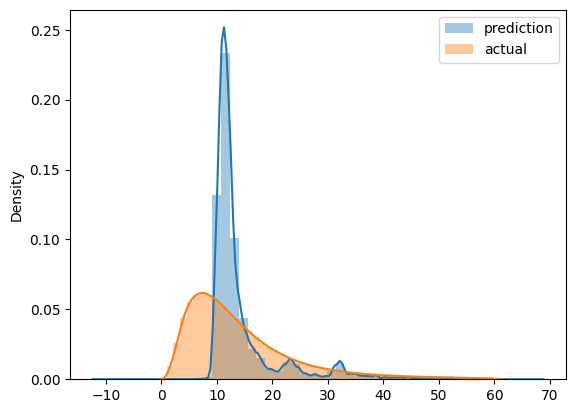

In [17]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
mean_squared_error(y_train, y_pred, squared=False)

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.658404942819061

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('data/yellow_tripdata_2023-02.parquet')

In [21]:
len(df_train), len(df_val)

(3009173, 2855951)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.247483997446876

In [26]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
with mlflow.start_run():

    mlflow.set_tag("developer",'bobbyboy')
    
    mlflow.log_param("train_data_path", "../data/yellow_tripdata_2023-01.parquet")
    mlflow.log_param("valid_data_path", "../data/yellow_tripdata_2023-01.parquet")

    alpha = 0.1    
    mlflow.log_param("alpha",alpha)


    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle/")

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


In [43]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain = train,
            num_boost_round=1000,
            evals=[(valid,"validation")],
            early_stopping_rounds=50
        )
        y_pred=booster.predict(valid)
        rmse=mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    
    return {'loss': rmse, 'status':STATUS_OK}

In [44]:
search_space={
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate':hp.loguniform('learning_rate', -3,0),
    'reg_alpha':hp.loguniform('reg_alpha', -5,1),
    'reg_lambda':hp.loguniform('reg_lambda', -6,1),
    'min_child_weight':hp.loguniform('min_child_weight', -1,3),
    'objective':'reg:linear',
    'seed':42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.38049                           
[1]	validation-rmse:4.88239                           
[2]	validation-rmse:4.81180                           
[3]	validation-rmse:4.78976                           
[4]	validation-rmse:4.78165                           
[5]	validation-rmse:4.77568                           
[6]	validation-rmse:4.76973                           
[7]	validation-rmse:4.76428                           
[8]	validation-rmse:4.75890                           
[9]	validation-rmse:4.75237                           
[10]	validation-rmse:4.74765                          
[11]	validation-rmse:4.74297                          
[12]	validation-rmse:4.73854                          
[13]	validation-rmse:4.73481                          
[14]	validation-rmse:4.73037                          
[15]	validation-rmse:4.72698                          
[16]	validation-rmse:4.72360                          
[17]	validation-rmse:4.71990                          
[18]	valid

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4.98846                                                      
[1]	validation-rmse:4.83298                                                      
[2]	validation-rmse:4.81226                                                      
[3]	validation-rmse:4.80277                                                      
[4]	validation-rmse:4.79455                                                      
[5]	validation-rmse:4.78709                                                      
[6]	validation-rmse:4.77997                                                      
[7]	validation-rmse:4.77433                                                      
[8]	validation-rmse:4.76856                                                      
[9]	validation-rmse:4.76320                                                      
[10]	validation-rmse:4.75840                                                     
[11]	validation-rmse:4.75344                                                     
[12]	validation-

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.93713                                                       
[1]	validation-rmse:8.02840                                                       
[2]	validation-rmse:7.30530                                                       
[3]	validation-rmse:6.73600                                                       
[4]	validation-rmse:6.29157                                                       
[5]	validation-rmse:5.94933                                                       
[6]	validation-rmse:5.68686                                                       
[7]	validation-rmse:5.48686                                                       
[8]	validation-rmse:5.33506                                                       
[9]	validation-rmse:5.21948                                                       
[10]	validation-rmse:5.13184                                                      
[11]	validation-rmse:5.06396                                                      
[12]

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:20:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.55644                                                       
[1]	validation-rmse:7.45786                                                       
[2]	validation-rmse:6.67617                                                       
[3]	validation-rmse:6.13171                                                       
[4]	validation-rmse:5.76060                                                       
[5]	validation-rmse:5.50861                                                       
[6]	validation-rmse:5.33859                                                       
[7]	validation-rmse:5.22389                                                       
[8]	validation-rmse:5.14472                                                       
[9]	validation-rmse:5.09115                                                       
[10]	validation-rmse:5.05179                                                      
[11]	validation-rmse:5.02311                                                      
[12]

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.74197                                                       
[1]	validation-rmse:5.27103                                                       
[2]	validation-rmse:5.21028                                                       
[3]	validation-rmse:5.19060                                                       
[4]	validation-rmse:5.18436                                                       
[5]	validation-rmse:5.17929                                                       
[6]	validation-rmse:5.17455                                                       
[7]	validation-rmse:5.16994                                                       
[8]	validation-rmse:5.15882                                                       
[9]	validation-rmse:5.15480                                                       
[10]	validation-rmse:5.15034                                                      
[11]	validation-rmse:5.14673                                                      
[12]

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.97483                                                       
[1]	validation-rmse:8.08494                                                       
[2]	validation-rmse:7.36667                                                       
[3]	validation-rmse:6.79211                                                       
[4]	validation-rmse:6.33779                                                       
[5]	validation-rmse:5.98060                                                       
[6]	validation-rmse:5.70269                                                       
[7]	validation-rmse:5.48748                                                       
[8]	validation-rmse:5.32183                                                       
[9]	validation-rmse:5.19316                                                       
[10]	validation-rmse:5.09355                                                      
[11]	validation-rmse:5.01808                                                      
[12]

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.60405                                                       
[1]	validation-rmse:9.17607                                                       
[2]	validation-rmse:8.78176                                                       
[3]	validation-rmse:8.41862                                                       
[4]	validation-rmse:8.08500                                                       
[5]	validation-rmse:7.77886                                                       
[6]	validation-rmse:7.49836                                                       
[7]	validation-rmse:7.24142                                                       
[8]	validation-rmse:7.00699                                                       
[9]	validation-rmse:6.79293                                                       
[10]	validation-rmse:6.59793                                                      
[11]	validation-rmse:6.42091                                                      
[12]

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.46870                                                       
[1]	validation-rmse:6.11311                                                       
[2]	validation-rmse:5.45287                                                       
[3]	validation-rmse:5.14393                                                       
[4]	validation-rmse:4.99551                                                       
[5]	validation-rmse:4.91923                                                       
[6]	validation-rmse:4.87566                                                       
[7]	validation-rmse:4.85176                                                       
[8]	validation-rmse:4.83225                                                       
[9]	validation-rmse:4.81870                                                       
[10]	validation-rmse:4.80773                                                      
[11]	validation-rmse:4.80059                                                      
[12]

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.90795                                                       
[1]	validation-rmse:7.97911                                                       
[2]	validation-rmse:7.24259                                                       
[3]	validation-rmse:6.66560                                                       
[4]	validation-rmse:6.21819                                                       
[5]	validation-rmse:5.87366                                                       
[6]	validation-rmse:5.61137                                                       
[7]	validation-rmse:5.41321                                                       
[8]	validation-rmse:5.26216                                                       
[9]	validation-rmse:5.14827                                                       
[10]	validation-rmse:5.06230                                                      
[11]	validation-rmse:4.99679                                                      
[12]

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.26726                                                       
[1]	validation-rmse:5.22936                                                       
[2]	validation-rmse:4.96798                                                       
[3]	validation-rmse:4.88645                                                       
[4]	validation-rmse:4.85467                                                       
[5]	validation-rmse:4.83718                                                       
[6]	validation-rmse:4.82531                                                       
[7]	validation-rmse:4.81963                                                       
[8]	validation-rmse:4.81519                                                       
[9]	validation-rmse:4.81105                                                       
[10]	validation-rmse:4.80718                                                      
[11]	validation-rmse:4.80281                                                      
[12]

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.21791                                                        
[1]	validation-rmse:6.97452                                                        
[2]	validation-rmse:6.16526                                                        
[3]	validation-rmse:5.65390                                                        
[4]	validation-rmse:5.33705                                                        
[5]	validation-rmse:5.14184                                                        
[6]	validation-rmse:5.02079                                                        
[7]	validation-rmse:4.94396                                                        
[8]	validation-rmse:4.89375                                                        
[9]	validation-rmse:4.85883                                                        
[10]	validation-rmse:4.83363                                                       
[11]	validation-rmse:4.81730                                                

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.27177                                                          
[1]	validation-rmse:4.89828                                                          
[2]	validation-rmse:4.84019                                                          
[3]	validation-rmse:4.82129                                                          
[4]	validation-rmse:4.81336                                                          
[5]	validation-rmse:4.80631                                                          
[6]	validation-rmse:4.79967                                                          
[7]	validation-rmse:4.79339                                                          
[8]	validation-rmse:4.78728                                                          
[9]	validation-rmse:4.78098                                                          
[10]	validation-rmse:4.77592                                                         
[11]	validation-rmse:4.76726                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:16:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4.94381                                                          
[1]	validation-rmse:4.90793                                                          
[2]	validation-rmse:4.89541                                                          
[3]	validation-rmse:4.88175                                                          
[4]	validation-rmse:4.86998                                                          
[5]	validation-rmse:4.86068                                                          
[6]	validation-rmse:4.85160                                                          
[7]	validation-rmse:4.84314                                                          
[8]	validation-rmse:4.83450                                                          
[9]	validation-rmse:4.82648                                                          
[10]	validation-rmse:4.81520                                                         
[11]	validation-rmse:4.80841                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:23:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.27474                                                          
[1]	validation-rmse:7.06913                                                          
[2]	validation-rmse:6.28315                                                          
[3]	validation-rmse:5.78665                                                          
[4]	validation-rmse:5.47881                                                          
[5]	validation-rmse:5.28836                                                          
[6]	validation-rmse:5.17091                                                          
[7]	validation-rmse:5.09476                                                          
[8]	validation-rmse:5.04623                                                          
[9]	validation-rmse:5.01454                                                          
[10]	validation-rmse:4.99032                                                         
[11]	validation-rmse:4.97484                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.86056                                                          
[1]	validation-rmse:5.54500                                                          
[2]	validation-rmse:5.05544                                                          
[3]	validation-rmse:4.87075                                                          
[4]	validation-rmse:4.79683                                                          
[5]	validation-rmse:4.75775                                                          
[6]	validation-rmse:4.73988                                                          
[7]	validation-rmse:4.72804                                                          
[8]	validation-rmse:4.71967                                                          
[9]	validation-rmse:4.71619                                                          
[10]	validation-rmse:4.71219                                                         
[11]	validation-rmse:4.70911                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:32:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.20284                                                          
[1]	validation-rmse:8.46482                                                          
[2]	validation-rmse:7.83805                                                          
[3]	validation-rmse:7.30945                                                          
[4]	validation-rmse:6.86562                                                          
[5]	validation-rmse:6.49475                                                          
[6]	validation-rmse:6.18698                                                          
[7]	validation-rmse:5.93343                                                          
[8]	validation-rmse:5.72405                                                          
[9]	validation-rmse:5.55273                                                          
[10]	validation-rmse:5.41298                                                         
[11]	validation-rmse:5.29887                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.56595                                                          
[1]	validation-rmse:9.10782                                                          
[2]	validation-rmse:8.69024                                                          
[3]	validation-rmse:8.31040                                                          
[4]	validation-rmse:7.96533                                                          
[5]	validation-rmse:7.65251                                                          
[6]	validation-rmse:7.36963                                                          
[7]	validation-rmse:7.11435                                                          
[8]	validation-rmse:6.88429                                                          
[9]	validation-rmse:6.67728                                                          
[10]	validation-rmse:6.49146                                                         
[11]	validation-rmse:6.32530                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:51:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.45714                                                          
[1]	validation-rmse:7.30566                                                          
[2]	validation-rmse:6.50163                                                          
[3]	validation-rmse:5.95331                                                          
[4]	validation-rmse:5.58463                                                          
[5]	validation-rmse:5.34126                                                          
[6]	validation-rmse:5.17901                                                          
[7]	validation-rmse:5.07125                                                          
[8]	validation-rmse:4.99751                                                          
[9]	validation-rmse:4.94759                                                          
[10]	validation-rmse:4.91120                                                         
[11]	validation-rmse:4.88546                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:58:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.23641                                                          
[1]	validation-rmse:7.01263                                                          
[2]	validation-rmse:6.22105                                                          
[3]	validation-rmse:5.72412                                                          
[4]	validation-rmse:5.41859                                                          
[5]	validation-rmse:5.23103                                                          
[6]	validation-rmse:5.11438                                                          
[7]	validation-rmse:5.03883                                                          
[8]	validation-rmse:4.99072                                                          
[9]	validation-rmse:4.95793                                                          
[10]	validation-rmse:4.93656                                                         
[11]	validation-rmse:4.91764                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:05:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.62815                                                          
[1]	validation-rmse:4.95692                                                          
[2]	validation-rmse:4.83933                                                          
[3]	validation-rmse:4.80685                                                          
[4]	validation-rmse:4.79042                                                          
[5]	validation-rmse:4.78159                                                          
[6]	validation-rmse:4.77590                                                          
[7]	validation-rmse:4.77044                                                          
[8]	validation-rmse:4.76615                                                          
[9]	validation-rmse:4.76149                                                          
[10]	validation-rmse:4.75819                                                         
[11]	validation-rmse:4.75492                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.41316                                                          
[1]	validation-rmse:8.83254                                                          
[2]	validation-rmse:8.31910                                                          
[3]	validation-rmse:7.86656                                                          
[4]	validation-rmse:7.46856                                                          
[5]	validation-rmse:7.12022                                                          
[6]	validation-rmse:6.81584                                                          
[7]	validation-rmse:6.55147                                                          
[8]	validation-rmse:6.32209                                                          
[9]	validation-rmse:6.12356                                                          
[10]	validation-rmse:5.95222                                                         
[11]	validation-rmse:5.80500                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:15:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.61456                                                          
[1]	validation-rmse:6.27172                                                          
[2]	validation-rmse:5.57995                                                          
[3]	validation-rmse:5.23692                                                          
[4]	validation-rmse:5.06535                                                          
[5]	validation-rmse:4.97556                                                          
[6]	validation-rmse:4.92486                                                          
[7]	validation-rmse:4.89680                                                          
[8]	validation-rmse:4.87911                                                          
[9]	validation-rmse:4.86415                                                          
[10]	validation-rmse:4.85340                                                         
[11]	validation-rmse:4.84592                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.39534                                                          
[1]	validation-rmse:6.12155                                                          
[2]	validation-rmse:5.56511                                                          
[3]	validation-rmse:5.33056                                                          
[4]	validation-rmse:5.22788                                                          
[5]	validation-rmse:5.17962                                                          
[6]	validation-rmse:5.15521                                                          
[7]	validation-rmse:5.14040                                                          
[8]	validation-rmse:5.13088                                                          
[9]	validation-rmse:5.12348                                                          
[10]	validation-rmse:5.12004                                                         
[11]	validation-rmse:5.11617                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.86987                                                          
[1]	validation-rmse:6.55651                                                          
[2]	validation-rmse:5.80806                                                          
[3]	validation-rmse:5.39767                                                          
[4]	validation-rmse:5.17445                                                          
[5]	validation-rmse:5.05137                                                          
[6]	validation-rmse:4.98113                                                          
[7]	validation-rmse:4.93765                                                          
[8]	validation-rmse:4.91038                                                          
[9]	validation-rmse:4.89211                                                          
[10]	validation-rmse:4.87634                                                         
[11]	validation-rmse:4.86728                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.39329                                                          
[1]	validation-rmse:5.26559                                                          
[2]	validation-rmse:4.95247                                                          
[3]	validation-rmse:4.85277                                                          
[4]	validation-rmse:4.81494                                                          
[5]	validation-rmse:4.79295                                                          
[6]	validation-rmse:4.77773                                                          
[7]	validation-rmse:4.76975                                                          
[8]	validation-rmse:4.76499                                                          
[9]	validation-rmse:4.76077                                                          
[10]	validation-rmse:4.75639                                                         
[11]	validation-rmse:4.75258                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.69914                                                          
[1]	validation-rmse:6.36237                                                          
[2]	validation-rmse:5.64976                                                          
[3]	validation-rmse:5.28458                                                          
[4]	validation-rmse:5.09457                                                          
[5]	validation-rmse:4.99521                                                          
[6]	validation-rmse:4.93872                                                          
[7]	validation-rmse:4.90646                                                          
[8]	validation-rmse:4.88113                                                          
[9]	validation-rmse:4.86795                                                          
[10]	validation-rmse:4.85585                                                         
[11]	validation-rmse:4.84654                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.61037                                                          
[1]	validation-rmse:7.54068                                                          
[2]	validation-rmse:6.77211                                                          
[3]	validation-rmse:6.23046                                                          
[4]	validation-rmse:5.85504                                                          
[5]	validation-rmse:5.59828                                                          
[6]	validation-rmse:5.42349                                                          
[7]	validation-rmse:5.30426                                                          
[8]	validation-rmse:5.22254                                                          
[9]	validation-rmse:5.16519                                                          
[10]	validation-rmse:5.12418                                                         
[11]	validation-rmse:5.09444                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.12559                                                          
[1]	validation-rmse:5.77838                                                          
[2]	validation-rmse:5.21691                                                          
[3]	validation-rmse:4.98494                                                          
[4]	validation-rmse:4.88218                                                          
[5]	validation-rmse:4.83090                                                          
[6]	validation-rmse:4.80477                                                          
[7]	validation-rmse:4.78734                                                          
[8]	validation-rmse:4.77361                                                          
[9]	validation-rmse:4.76571                                                          
[10]	validation-rmse:4.75835                                                         
[11]	validation-rmse:4.75448                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.92737                                                          
[1]	validation-rmse:6.59840                                                          
[2]	validation-rmse:5.81012                                                          
[3]	validation-rmse:5.35763                                                          
[4]	validation-rmse:5.10273                                                          
[5]	validation-rmse:4.95816                                                          
[6]	validation-rmse:4.87529                                                          
[7]	validation-rmse:4.82325                                                          
[8]	validation-rmse:4.79019                                                          
[9]	validation-rmse:4.76718                                                          
[10]	validation-rmse:4.75232                                                         
[11]	validation-rmse:4.74015                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:01:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.47864                                                          
[1]	validation-rmse:5.35288                                                          
[2]	validation-rmse:5.03050                                                          
[3]	validation-rmse:4.92270                                                          
[4]	validation-rmse:4.87860                                                          
[5]	validation-rmse:4.85758                                                          
[6]	validation-rmse:4.84653                                                          
[7]	validation-rmse:4.83616                                                          
[8]	validation-rmse:4.83122                                                          
[9]	validation-rmse:4.82710                                                          
[10]	validation-rmse:4.82082                                                         
[11]	validation-rmse:4.81675                          

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.74411                                                          
[1]	validation-rmse:7.72434                                                          
[2]	validation-rmse:6.95002                                                          
[3]	validation-rmse:6.37079                                                          
[4]	validation-rmse:5.94437                                                          
[5]	validation-rmse:5.63219                                                          
[6]	validation-rmse:5.40636                                                          
[7]	validation-rmse:5.24428                                                          
[8]	validation-rmse:5.12741                                                          
[9]	validation-rmse:5.04178                                                          
[10]	validation-rmse:4.97867                                                         
[11]	validation-rmse:4.93281                          

KeyboardInterrupt: 

In [45]:
# can simply pick the best output found through mlflow web interface and manaully input, below you can log more efficiently along with additional manual logs if you wish, using autolog()
params={
    'learning_rate': 0.2047216980371677,
    'max_depth':17,
    'min_child_weight': 1.2402611720043835,
    'objective':'reg:linear',
    'reg_alpha':0.28567896734700793,
    'reg_lambda':0.004264404814393109,
    'seed':42
    }  

# https://mlflow.org/docs/latest/tracking/autolog.html
mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain = train,
    num_boost_round=1000,
    evals=[(valid,"validation")],
    early_stopping_rounds=50
)

2024/05/27 03:18:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9d80c10c230a40f2923bf5b7e597486c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2024/05/27 03:18:02 WARNING mlflow.xgboost: Failed to log dataset information to MLflow Tracking. Reason: Unable to allocate 244. GiB for an array with shape (3009173, 21802) and data type float32
c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.62255
[1]	validation-rmse:7.55517
[2]	validation-rmse:6.78468
[3]	validation-rmse:6.23723
[4]	validation-rmse:5.85523
[5]	validation-rmse:5.59249
[6]	validation-rmse:5.41233
[7]	validation-rmse:5.28765
[8]	validation-rmse:5.20131
[9]	validation-rmse:5.14225
[10]	validation-rmse:5.09910
[11]	validation-rmse:5.06815
[12]	validation-rmse:5.04572
[13]	validation-rmse:5.03009
[14]	validation-rmse:5.01739
[15]	validation-rmse:5.00639
[16]	validation-rmse:4.99750
[17]	validation-rmse:4.99096
[18]	validation-rmse:4.98448
[19]	validation-rmse:4.97860
[20]	validation-rmse:4.97359
[21]	validation-rmse:4.96989
[22]	validation-rmse:4.96662
[23]	validation-rmse:4.96503
[24]	validation-rmse:4.96338
[25]	validation-rmse:4.96118
[26]	validation-rmse:4.95980
[27]	validation-rmse:4.95845
[28]	validation-rmse:4.95676
[29]	validation-rmse:4.95539
[30]	validation-rmse:4.95421
[31]	validation-rmse:4.95284
[32]	validation-rmse:4.95163
[33]	validation-rmse:4.95029
[34]	validation-rmse:4.9

2024/05/27 03:22:32 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/27 03:22:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [22]:
mlflow.xgboost.autolog(disable=True)

In [23]:
with mlflow.start_run():

    train=xgb.DMatrix(X_train, label=y_train)
    valid=xgb.DMatrix(X_val, label=y_val)

    best_params={
        'learning_rate':0.2578026927178492,
        'max_depth':58,
        'min_child_weight': 5.373783583175782,
        'objective':'reg:squarederror',
        'reg_alpha':2.509806147038643,
        'reg_lambda':0.07277513989769854,
        'seed':42
    }  

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain = train,
        num_boost_round=1000,
        evals=[(valid,"validation")],
        early_stopping_rounds=50
    )
    
    y_pred=booster.predict(valid)
    rmse=mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv,f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path='preprocessor')

    # https://mlflow.org/docs/latest/tracking/autolog.html
    # this is the preferred way to save and log the model
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

    # # Log feature importance plot with a limit on the number of features
    # import matplotlib.pyplot as plt

    # importance = booster.get_score(importance_type='weight')
    # importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    # top_20_importance = dict(importance[:20])

    # plt.figure(figsize=(10, 6))
    # plt.barh(range(len(top_20_importance)), list(top_20_importance.values()), align='center')
    # plt.yticks(range(len(top_20_importance)), list(top_20_importance.keys()))
    # plt.xlabel('Feature Importance')
    # plt.title('Top 20 Feature Importances')

    # # Save the plot to a file
    # plt.tight_layout()
    # plt.savefig("feature_importance.png")

    # # Log the plot to MLflow
    # mlflow.log_artifact("feature_importance.png")

[0]	validation-rmse:8.21791
[1]	validation-rmse:6.97452
[2]	validation-rmse:6.16526
[3]	validation-rmse:5.65390
[4]	validation-rmse:5.33705
[5]	validation-rmse:5.14184
[6]	validation-rmse:5.02079
[7]	validation-rmse:4.94396
[8]	validation-rmse:4.89375
[9]	validation-rmse:4.85883
[10]	validation-rmse:4.83363
[11]	validation-rmse:4.81730
[12]	validation-rmse:4.80487
[13]	validation-rmse:4.79406
[14]	validation-rmse:4.78416
[15]	validation-rmse:4.77768
[16]	validation-rmse:4.77077
[17]	validation-rmse:4.76482
[18]	validation-rmse:4.76101
[19]	validation-rmse:4.75768
[20]	validation-rmse:4.75593
[21]	validation-rmse:4.75418
[22]	validation-rmse:4.75101
[23]	validation-rmse:4.74927
[24]	validation-rmse:4.74773
[25]	validation-rmse:4.74627
[26]	validation-rmse:4.74483
[27]	validation-rmse:4.74336
[28]	validation-rmse:4.74193
[29]	validation-rmse:4.74028
[30]	validation-rmse:4.73899
[31]	validation-rmse:4.73771
[32]	validation-rmse:4.73658
[33]	validation-rmse:4.73521
[34]	validation-rmse:4.7

c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\xgboost\core.py:160: UserWarning: [04:14:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
c:\Users\Comp2\anaconda3\envs\mlopszoomcamp\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors

In [24]:
#grab the following from mlflow web 

import mlflow
logged_model = 'runs:/5d497f379bbd41d2b4a338fac06af4aa/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [25]:
# loaded as python flavor directly with the code provided from mlflow
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 5d497f379bbd41d2b4a338fac06af4aa

In [26]:
# change to xgboost flavor
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

In [27]:
# can now use to make predictions
y_pred = xgboost_model.predict(valid)

In [28]:
y_pred[:10]

array([ 3.2021365, 43.723347 , 15.654148 , 22.476496 , 23.377258 ,
        7.1701493, 18.0176   ,  4.3297405,  5.618409 ,  9.702162 ],
      dtype=float32)

In [29]:
# alternative to using mlflow UI web interface, can also acheive all functionalities using python with the MlflowClient Class

from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri="sqlite:///mlflow.db")